In [19]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

class Skill:
    def __init__(self, name, preconditions, action_sequence, embedding, success_count=0):
        self.name = name
        self.preconditions = preconditions
        self.action_sequence = action_sequence
        self.embedding = embedding
        self.success_count = success_count
        self.times_used = 0

    def is_applicable(self, state):
        for key, value in self.preconditions.items():
            if state.get(key) != value:
                return False
        return True

    def __repr__(self):
        return f"Skill({self.name}, used={self.times_used}, success={self.success_count})"

class SkillLibrary:
    def __init__(self, embedding_dim=8):
        self.skills = []
        self.embedding_dim = embedding_dim
        self.skill_stats = defaultdict(lambda: {"attempts": 0, "successes": 0})

    def add_skill(self, skill):
        for existing_skill in self.skills:
            if self._similarity(skill.embedding, existing_skill.embedding) > 0.9:
                existing_skill.success_count += 1
                return existing_skill
        self.skills.append(skill)
        return skill

    def retrieve_skills(self, state, query_embedding=None, top_k=3):
        applicable = [s for s in self.skills if s.is_applicable(state)]
        if query_embedding is not None and applicable:
            similarities = [self._similarity(query_embedding, s.embedding) for s in applicable]
            sorted_skills = [s for _, s in sorted(zip(similarities, applicable), reverse=True)]
            return sorted_skills[:top_k]
        return sorted(applicable, key=lambda s: s.success_count / max(s.times_used, 1), reverse=True)[:top_k]

    def _similarity(self, emb1, emb2):
        return np.dot(emb1, emb2) / (np.linalg.norm(emb1) * np.linalg.norm(emb2) + 1e-8)

    def get_stats(self):
        return {
            "total_skills": len(self.skills),
            "total_uses": sum(s.times_used for s in self.skills),
            "avg_success_rate": np.mean([s.success_count / max(s.times_used, 1) for s in self.skills]) if self.skills else 0
        }

In [20]:
class GridWorld:
    def __init__(self, size=5):
        self.size = size
        self.reset()

    def reset(self):
        self.agent_pos = [0, 0]
        self.goal_pos = [self.size-1, self.size-1]
        self.objects = {"key": [2, 2], "door": [3, 3], "box": [1, 3]}
        self.inventory = []
        self.door_open = False
        return self.get_state()

    def get_state(self):
        return {
            "agent_pos": tuple(self.agent_pos),
            "has_key": "key" in self.inventory,
            "door_open": self.door_open,
            "at_goal": self.agent_pos == self.goal_pos,
            "objects": {k: tuple(v) for k, v in self.objects.items()}
        }

    def step(self, action):
        reward = -0.1
        if action == "move_up":
            self.agent_pos[1] = min(self.agent_pos[1] + 1, self.size - 1)
        elif action == "move_down":
            self.agent_pos[1] = max(self.agent_pos[1] - 1, 0)
        elif action == "move_left":
            self.agent_pos[0] = max(self.agent_pos[0] - 1, 0)
        elif action == "move_right":
            self.agent_pos[0] = min(self.agent_pos[0] + 1, self.size - 1)
        elif action == "pickup_key":
            if self.agent_pos == self.objects["key"] and "key" not in self.inventory:
                self.inventory.append("key")
                reward = 1.0
        elif action == "open_door":
            if self.agent_pos == self.objects["door"] and "key" in self.inventory:
                self.door_open = True
                reward = 2.0
        done = self.agent_pos == self.goal_pos and self.door_open
        if done:
            reward = 10.0
        return self.get_state(), reward, done

In [23]:
class ProceduralMemoryAgent:
    def __init__(self, env, embedding_dim=8):
        self.env = env
        self.skill_library = SkillLibrary(embedding_dim)
        self.embedding_dim = embedding_dim
        self.episode_history = []
        self.primitive_actions = ["move_up", "move_down", "move_left", "move_right", "pickup_key", "open_door"]

    def create_embedding(self, state, action_seq):
        state_vec = np.zeros(self.embedding_dim)
        state_vec[0] = hash(str(state["agent_pos"])) % 1000 / 1000
        state_vec[1] = 1.0 if state.get("has_key") else 0.0
        state_vec[2] = 1.0 if state.get("door_open") else 0.0
        for i, action in enumerate(action_seq[:self.embedding_dim-3]):
            state_vec[3+i] = hash(action) % 1000 / 1000
        return state_vec / (np.linalg.norm(state_vec) + 1e-8)

    def extract_skill(self, trajectory):
        if len(trajectory) < 2:
            return None
        start_state = trajectory[0][0]
        actions = [a for _, a, _ in trajectory]
        preconditions = {"has_key": start_state.get("has_key", False), "door_open": start_state.get("door_open", False)}
        end_state = self.env.get_state()
        if end_state.get("has_key") and not start_state.get("has_key"):
            name = "acquire_key"
        elif end_state.get("door_open") and not start_state.get("door_open"):
            name = "open_door_sequence"
        else:
            name = f"navigate_{len(actions)}_steps"
        embedding = self.create_embedding(start_state, actions)
        return Skill(name, preconditions, actions, embedding, success_count=1)

    def execute_skill(self, skill):
        skill.times_used += 1
        trajectory = []
        total_reward = 0
        for action in skill.action_sequence:
            state = self.env.get_state()
            next_state, reward, done = self.env.step(action)
            trajectory.append((state, action, reward))
            total_reward += reward
            if done:
                skill.success_count += 1
                return trajectory, total_reward, True
        return trajectory, total_reward, False

    def explore(self, max_steps=20):
        trajectory = []
        state = self.env.get_state()
        for _ in range(max_steps):
            action = self._choose_exploration_action(state)
            next_state, reward, done = self.env.step(action)
            trajectory.append((state, action, reward))
            state = next_state
            if done:
                return trajectory, True
        return trajectory, False
    
    def _choose_exploration_action(self, state):
       agent_pos = state["agent_pos"]
       if not state.get("has_key"):
           key_pos = state["objects"]["key"]
           if agent_pos == key_pos:
               return "pickup_key"
           if agent_pos[0] < key_pos[0]:
               return "move_right"
           if agent_pos[0] > key_pos[0]:
               return "move_left"
           if agent_pos[1] < key_pos[1]:
               return "move_up"
           return "move_down"
       if state.get("has_key") and not state.get("door_open"):
           door_pos = state["objects"]["door"]
           if agent_pos == door_pos:
               return "open_door"
           if agent_pos[0] < door_pos[0]:
               return "move_right"
           if agent_pos[0] > door_pos[0]:
               return "move_left"
           if agent_pos[1] < door_pos[1]:
               return "move_up"
           return "move_down"
       goal_pos = (4, 4)
       if agent_pos[0] < goal_pos[0]:
           return "move_right"
       if agent_pos[1] < goal_pos[1]:
           return "move_up"
       return np.random.choice(self.primitive_actions)
  
    def run_episode(self, use_skills=True):
        self.env.reset()
        total_reward = 0
        steps = 0
        trajectory = []
        while steps < 50:
            state = self.env.get_state()
            if use_skills and self.skill_library.skills:
                query_emb = self.create_embedding(state, [])
                skills = self.skill_library.retrieve_skills(state, query_emb, top_k=1)
                if skills:
                    skill_traj, skill_reward, success = self.execute_skill(skills[0])
                    trajectory.extend(skill_traj)
                    total_reward += skill_reward
                    steps += len(skill_traj)
                    if success:
                        return trajectory, total_reward, steps, True
                    continue
            action = self._choose_exploration_action(state)
            next_state, reward, done = self.env.step(action)
            trajectory.append((state, action, reward))
            total_reward += reward
            steps += 1
            if done:
                return trajectory, total_reward, steps, True
        return trajectory, total_reward, steps, False
  
    def train(self, episodes=10):
        stats = {"rewards": [], "steps": [], "skills_learned": [], "skill_uses": []}
        for ep in range(episodes):
            trajectory, reward, steps, success = self.run_episode(use_skills=True)
            if success and len(trajectory) >= 3:
                segment = trajectory[-min(5, len(trajectory)):]
                skill = self.extract_skill(segment)
                if skill:
                    self.skill_library.add_skill(skill)
            stats["rewards"].append(reward)
            stats["steps"].append(steps)
            stats["skills_learned"].append(len(self.skill_library.skills))
            stats["skill_uses"].append(self.skill_library.get_stats()["total_uses"])
            print(f"Episode {ep+1}: Reward={reward:.1f}, Steps={steps}, Skills={len(self.skill_library.skills)}, Success={success}")
        return stats

=== Procedural Memory Agent Demo ===

Training agent to learn reusable skills...

Episode 1: Reward=12.3, Steps=10, Skills=1, Success=True
Episode 2: Reward=12.3, Steps=10, Skills=1, Success=True
Episode 3: Reward=12.3, Steps=10, Skills=1, Success=True
Episode 4: Reward=12.3, Steps=10, Skills=1, Success=True
Episode 5: Reward=12.3, Steps=10, Skills=1, Success=True
Episode 6: Reward=12.3, Steps=10, Skills=1, Success=True
Episode 7: Reward=12.3, Steps=10, Skills=1, Success=True
Episode 8: Reward=12.3, Steps=10, Skills=1, Success=True
Episode 9: Reward=12.3, Steps=10, Skills=1, Success=True
Episode 10: Reward=12.3, Steps=10, Skills=1, Success=True
Episode 11: Reward=12.3, Steps=10, Skills=1, Success=True
Episode 12: Reward=12.3, Steps=10, Skills=1, Success=True
Episode 13: Reward=12.3, Steps=10, Skills=1, Success=True
Episode 14: Reward=12.3, Steps=10, Skills=1, Success=True
Episode 15: Reward=12.3, Steps=10, Skills=1, Success=True

=== Learned Skills ===
open_door_sequence: 5 actions, us

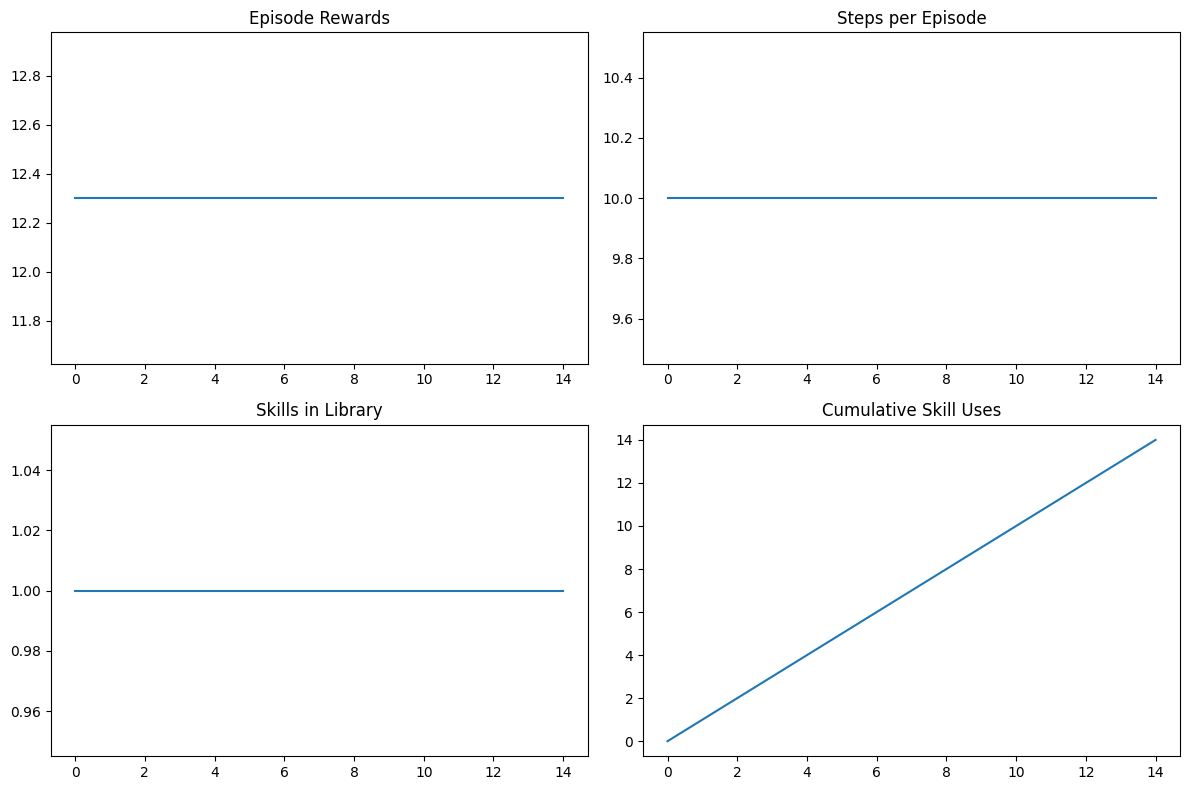


✓ Skill learning complete! Check the visualization above.


In [24]:
def visualize_training(stats):
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    axes[0, 0].plot(stats["rewards"])
    axes[0, 0].set_title("Episode Rewards")
    axes[0, 1].plot(stats["steps"])
    axes[0, 1].set_title("Steps per Episode")
    axes[1, 0].plot(stats["skills_learned"])
    axes[1, 0].set_title("Skills in Library")
    axes[1, 1].plot(stats["skill_uses"])
    axes[1, 1].set_title("Cumulative Skill Uses")
    plt.tight_layout()
    plt.savefig("skill_learning_stats.png", dpi=150, bbox_inches='tight')
    plt.show()

if __name__ == "__main__":
    print("=== Procedural Memory Agent Demo ===\n")
    env = GridWorld(size=5)
    agent = ProceduralMemoryAgent(env)
    print("Training agent to learn reusable skills...\n")
    stats = agent.train(episodes=15)
    print("\n=== Learned Skills ===")
    for skill in agent.skill_library.skills:
        print(f"{skill.name}: {len(skill.action_sequence)} actions, used {skill.times_used} times, {skill.success_count} successes")
    lib_stats = agent.skill_library.get_stats()
    print(f"\n=== Library Statistics ===")
    print(f"Total skills: {lib_stats['total_skills']}")
    print(f"Total skill uses: {lib_stats['total_uses']}")
    print(f"Avg success rate: {lib_stats['avg_success_rate']:.2%}")
    visualize_training(stats)
    print("\n✓ Skill learning complete! Check the visualization above.")